### 본 과제는 영화 대사를 학습데이터로 사용하여 transformer로 챗봇을 구현하는 과제입니다.



## 라이브러리 설치, 경로 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
from collections import Counter
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import math
import torch.nn.functional as F

In [7]:
corpus_movie_conv = '/Users/happykuma/Documents/kubig/nlp/week4/movie_conversations.txt'
corpus_movie_lines =  '/Users/happykuma/Documents/kubig/nlp/week4/movie_lines.txt'
max_len = 25

In [8]:
with open(corpus_movie_conv, 'r') as c:
    conv = c.readlines()

with open(corpus_movie_lines, 'r',encoding= 'unicode_escape') as l:
    lines = l.readlines()

## txt 파일 불러오고 전처리해주기

`movie_lines.txt` 파일에는 영화 대사들이 주어져있습니다. 총 5개의 컬럼이 `+++$+++`라는 구분자로 나뉘어 있는데, 이 중에서 사용할 것은 대사(line)의 id인 첫번째 컬럼과 대사 text인 마지막 컬럼입니다. 아래 코드를 보면 key를 대사 id로 하고 value를 대사 text로 하는 딕셔너리를 만들었습니다.

참고) lines를 출력해서 직접 확인해보세요
- 1열: 대사 id
- 2열: 대사를 한 캐릭터 id
- 3열: 영화 id
- 4열: 캐릭터 이름
- 5열: 대사 내용 text

In [9]:
lines[:5]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"]

In [10]:
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1] #object[0]이 대사 id, object[-1]이 대사 내용 text

In [11]:
print("총 대사(line)의 개수:",len(lines_dic))

총 대사(line)의 개수: 304713


In [ ]:
## 구두점, 기호를 없애주고 소문자로 바꿔주는 함수
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # 띄어쓰기 포함하여 기호가 아닌 문자 전부 포함
    return no_punct.lower()

## 대사 쌍(pairs) 만들어주기

챗봇은 질문과 답변으로 구성됩니다. 즉 학습데이터 역시 질문 문장과 답변 문장의 쌍(pair)으로 구성이 되어야 합니다. 아까 불러온 대사(line)들을 pair로 짝지어주기 위한 정보를 `movie_converstion.txt` 파일에서 불러올 것입니다.

또한 트랜스포머에 입력 데이터로 넣기 위해 단어(토큰) 단위로 split을 해줘야 합니다.


`movie_conversations.txt` 파일은 아래 사진처럼 구성되어 있습니다.
- 1열: 대화에 등장하는 첫번째 캐릭터의 id
- 2열: 대화에 등장하는 두번째 캐릭터의 id
- 3열: 영화 id
- 4열: 대화가 구성되는 line들의 리스트

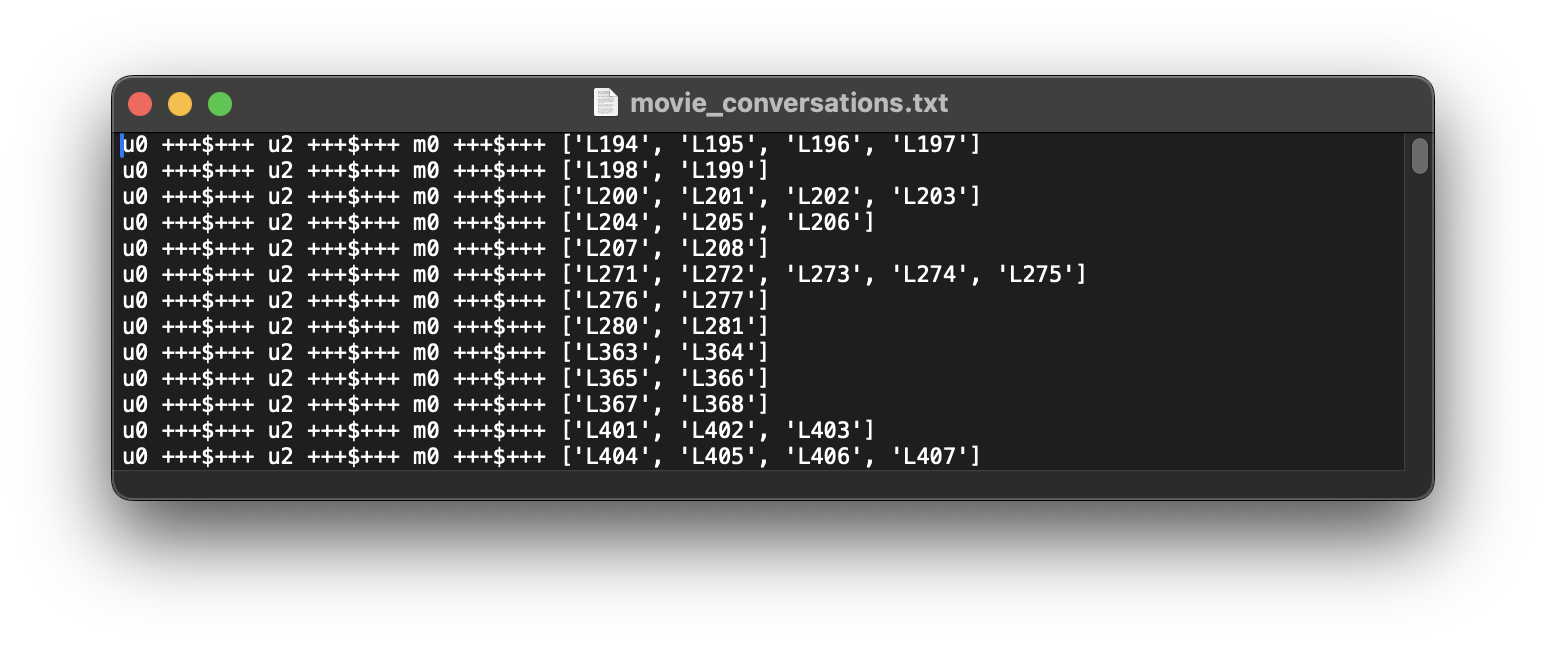

위 사진처럼 L194, L195, L196, L197이 하나의 conversation으로 묶여있다고 가정합니다. 이 때 아래 함수는 L194, L195를 하나의 pair로, L195, L196을 하나의 pair로, L196, L197을 하나의 pair로 만들어줍니다.

즉 pairs라는 리스트를 보면 아래처럼 구성될 것입니다.
- `pairs[0]: [[L194 대사의 단어들 토큰 리스트], [L195 대사의 단어들 토큰 리스트]]`
- `pairs[1]: [[L195 대사의 단어들 토큰 리스트], [L196 대사의 단어들 토큰 리스트]]`
- `pairs[2]: [[L196 대사의 단어들 토큰 리스트], [L197 대사의 단어들 토큰 리스트]]`
- `pairs[3]: [[L198 대사의 단어들 토큰 리스트], [L199 대사의 단어들 토큰 리스트]]`

In [ ]:
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1]) # 각 행의 line 리스트를 ids에 저장
    for i in range(len(ids)):
        qa_pairs = []

        if i==len(ids)-1: # 마지막 문장일 경우
            break

        first = remove_punc(lines_dic[ids[i]].strip()) # 기호 제거
        second = remove_punc(lines_dic[ids[i+1]].strip())
        qa_pairs.append(first.split()[:max_len]) # 띄어쓰기 단위로 split해주고 max_len(25)개만큼의 단어만 담을 것임
        qa_pairs.append(second.split()[:max_len])
        pairs.append(qa_pairs)

In [14]:
print(lines_dic['L194']) # 질문
print(lines_dic['L195']) # 답변

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.

Well, I thought we'd start with pronunciation, if that's okay with you.



In [15]:
print(pairs[0][0]) # 질문
print(pairs[0][1]) # 답변

['can', 'we', 'make', 'this', 'quick', 'roxanne', 'korrine', 'and', 'andrew', 'barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break', 'up', 'on', 'the', 'quad', 'again']
['well', 'i', 'thought', 'wed', 'start', 'with', 'pronunciation', 'if', 'thats', 'okay', 'with', 'you']


In [16]:
print("만들어진 문장 pairs의 개수:",len(pairs))

만들어진 문장 pairs의 개수: 221616


`Counter.update()`는 추가된 리스트를 누적하여 카운팅해줍니다.

In [17]:
word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

## 정수 인코딩하여 시퀀스 형태로 변형

counting 결과 빈도수가 5를 넘는 단어들만 `word_map` 딕셔너리에 정수 인코딩하여 담아줍니다. 이 때 네 가지 스페셜 토큰들도 정수 인코딩을 해줍니다.

In [18]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1 #18240
word_map['<start>'] = len(word_map) + 1 #18241
word_map['<end>'] = len(word_map) + 1 #18242
word_map['<pad>'] = 0

In [19]:
print("Total words are: {}".format(len(word_map)))

Total words are: 18243


In [20]:
# 생성한 word_map을 dump해준다.
with open('WORDMAP_corpus.json', 'w') as j:
    json.dump(word_map, j)

정수 인코딩 정보가 들어있는 `word_map`을 토대로 question 대사와 reply 문장을 정수 인코딩하여 시퀀스 형태로 만들 것입니다.

question은 대사를 정수인코딩 하고 뒤에 남는 부분을 패딩하는 반면, reply는 시작과 끝에 `<start>`, `<end>` 토큰을 넣고 뒤에 남는 부분을 패딩합니다.

In [22]:
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
    [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

인코딩된 pairs가 `pairs_encoded` 리스트에 담깁니다.

In [23]:
pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)
    pairs_encoded.append([qus, ans])

In [24]:
# 생성한 pairs_encoded을 dump 해준다.
with open('pairs_encoded.json', 'w') as p:
    json.dump(pairs_encoded, p)

## dataset 만들기

In [25]:
class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):

        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])

        return question, reply

    def __len__(self):
        return self.dataset_size

In [26]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100,
                                           shuffle=True,
                                           pin_memory=True)

데이터셋 준비가 완료되었으니 본격적으로 transformer 구조를 구현해보도록 합시다. 대략적인 구조는 아래 사진과 같습니다. 크게 인코더와 디코더로 나뉘고, 각각은 2개의 서브층과 3개의 서브층을 가지고 있습니다.

인코더, 디코더 모두 단어 임베딩을 시킨 후 positional encoding까지 시킨 것을 입력값으로 받고 있습니다.

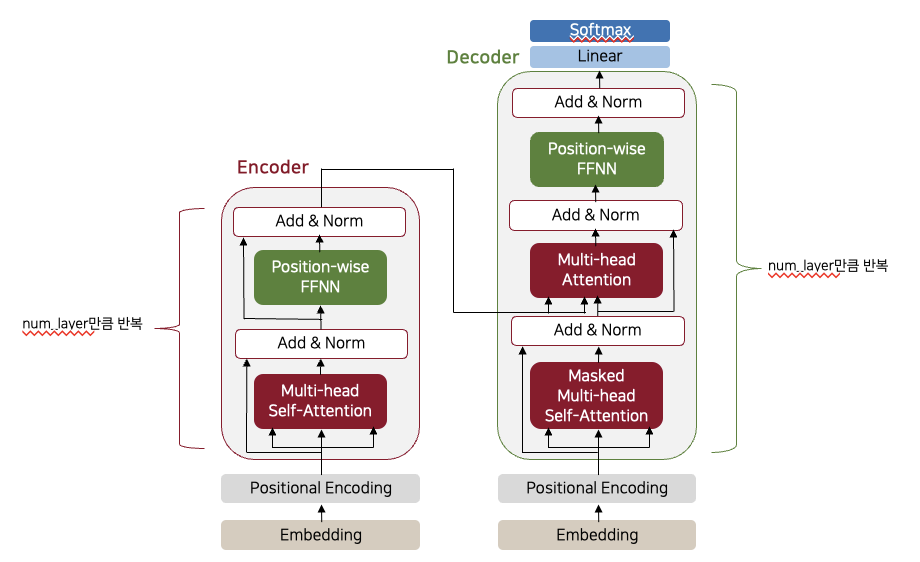

## Masking

아래 함수는 참고하면 안되는 토큰들을 가려주는 mask를 구현한 것이다. 후술하겠지만, 트랜스포머 구조에는 3개의 multi-head 어텐션이 있는데, 각각은 아래 같은 mask 기법을 사용합니다.
- 인코더의 첫번째 서브층: `padding mask`
- 디코더의 첫번째 서브층: `look-ahead mask`
- 디코더의 두번째 서브층: `padding mask`

In [27]:
def create_masks(question, reply_input, reply_target):

    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        return mask.unsqueeze(0)

    question_mask = question!=0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)

    reply_input_mask = reply_input!=0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data)
    reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
    reply_target_mask = reply_target!=0              # (batch_size, max_words)

    return question_mask, reply_input_mask, reply_target_mask

## 포지셔널 인코딩(Positional Encoding)

트랜스포머는 RNN과 달리 각 단어의 위치 정보를 알 수 없다는 단점을 지닙니다. 때문에 Positional encoding을 통해 임베딩 벡터를 만들 때 위치 정보를 더하는 작업을 거쳐줘야 합니다. 그리하여 같은 단어라고 하더라도 문장 내 위치에 따라 임베딩 벡터값은 달라지게 됩니다.

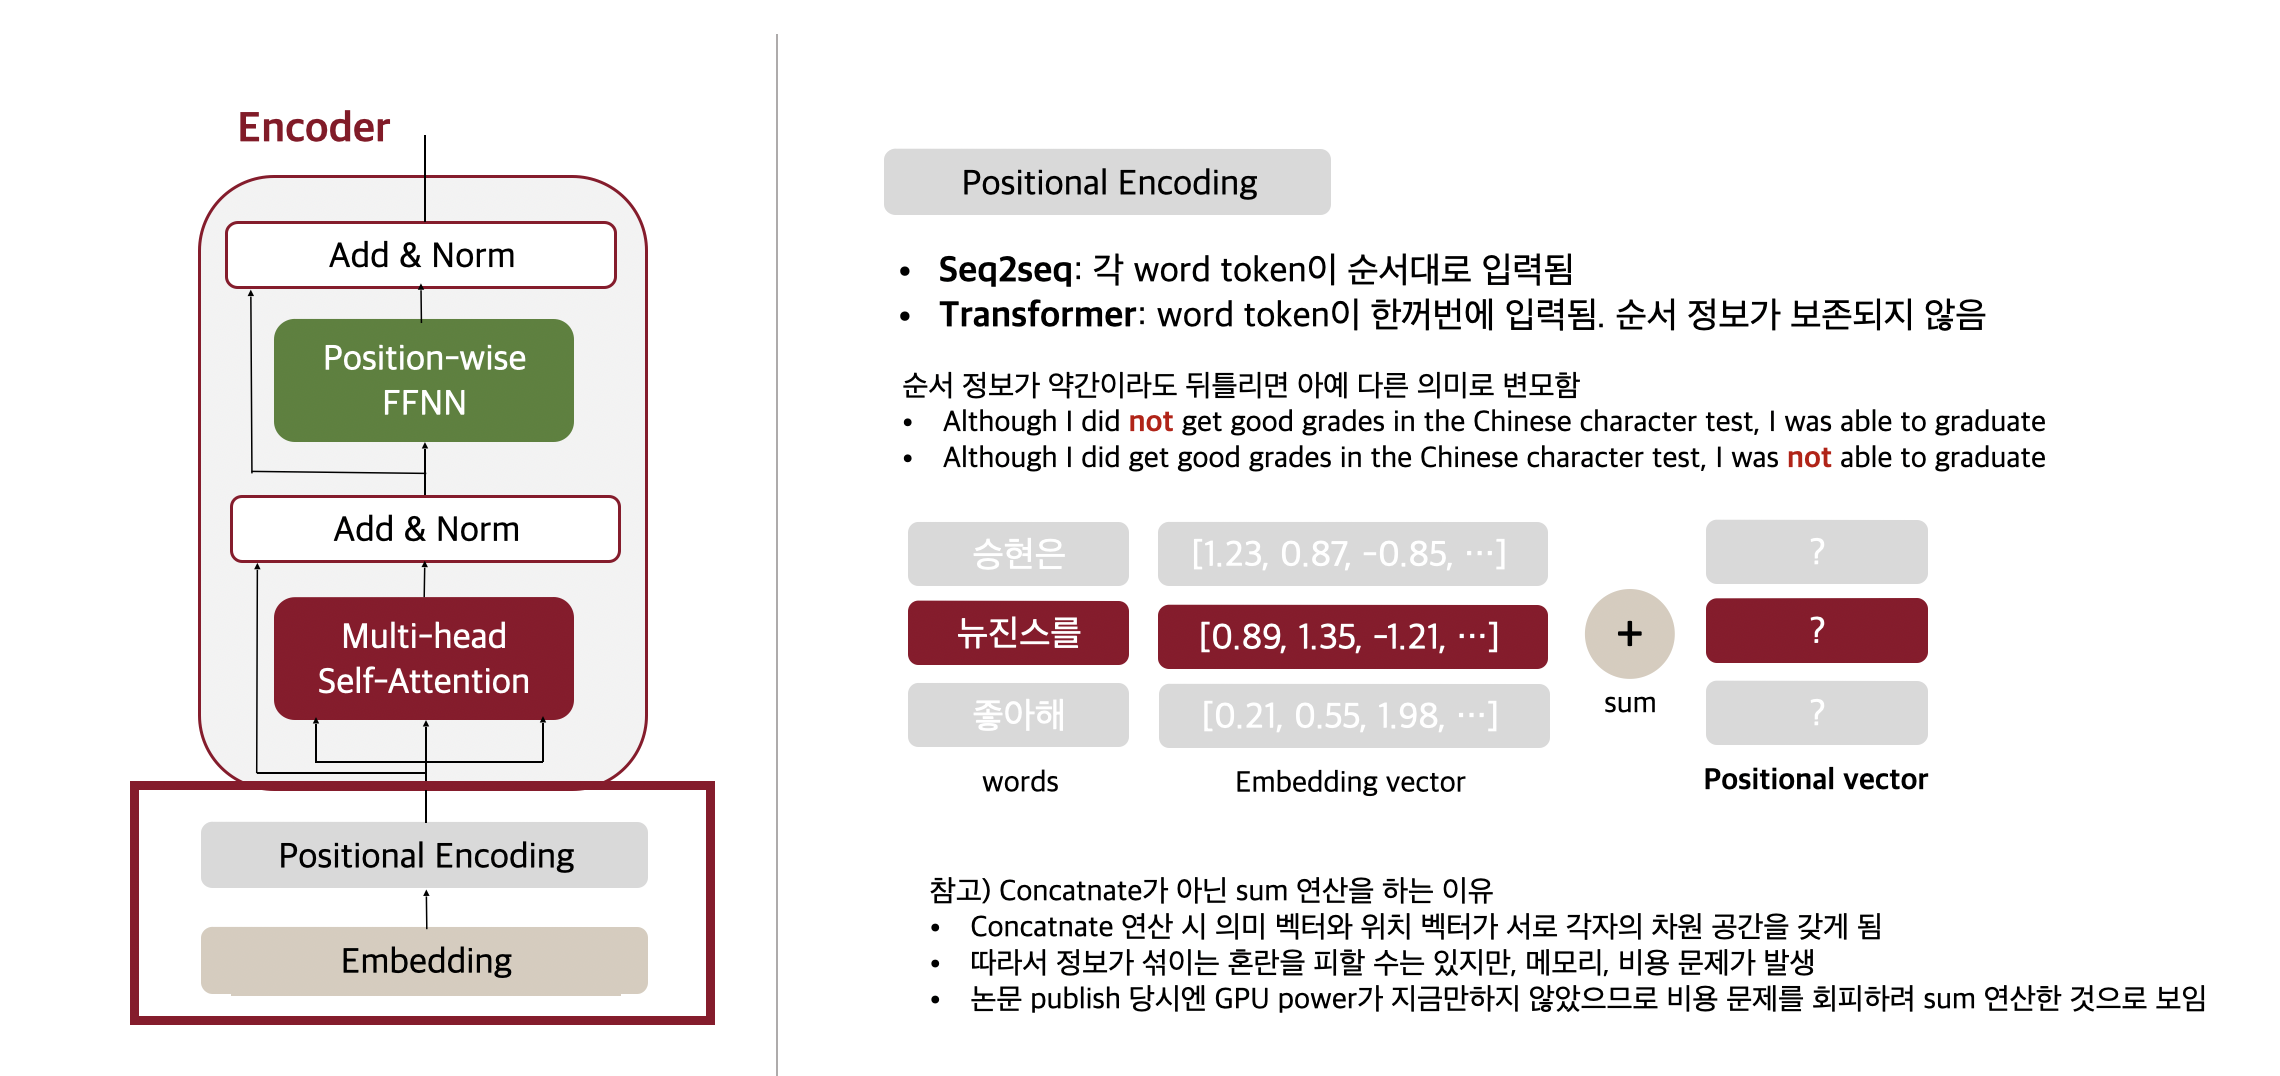

In [40]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings.
    """
    def __init__(self, vocab_size, d_model, max_len = 50):
        super(Embeddings, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(0.1)
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = self.create_positinal_encoding(max_len, self.d_model)
        self.dropout = nn.Dropout(0.1)

    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # 각 단어의 위치
            for i in range(0, d_model, 2):   # 한 단어 내에서의 dimension

                """
                문제1: Positional Encoding을 수행할 때에 짝수의 경우 sin 함수를, 홀수의 경우 cos 함수를 사용합니다.
                강의안에 나온 Positional Encoding 수식을 참고하여 아래 코드를 작성해주세요!
                hint: sin 함수는 math.sin, cos 함수는 math.cos을 사용할 수 있습니다.
                """
                pe[pos, i] = math.sin(pos/(10000**(i/d_model)))
                pe[pos, i + 1] = math.cos(pos/(10000**((i+1)/d_model)))

        pe = pe.unsqueeze(0)   # 첫번째 차원에 1(batch size)을 추가
        return pe

    def forward(self, encoded_words):
        embedding = self.embed(encoded_words) * math.sqrt(self.d_model)
        # 임베딩 벡터의 행렬과 포지셔널 인코딩 행렬을 덧셈 연산해준다.
        embedding += self.pe[:, :embedding.size(1)]
        embedding = self.dropout(embedding)
        return embedding

## 멀티헤드 어텐션(Multi-Head Attention)

`MultiHeadAttention`은 어텐션을 병렬로 수행하는 것입니다. 한 번의 어텐션보다 여러번의 어텐션을 병렬로 수행하는 것이 더 효과적이기 때문에 8개의 병렬 어텐션을 주로 사용합니다. 몇 개를 사용할지는 아래 코드에서 `heads`라는 파라미터로 결정할 수 있습니다.

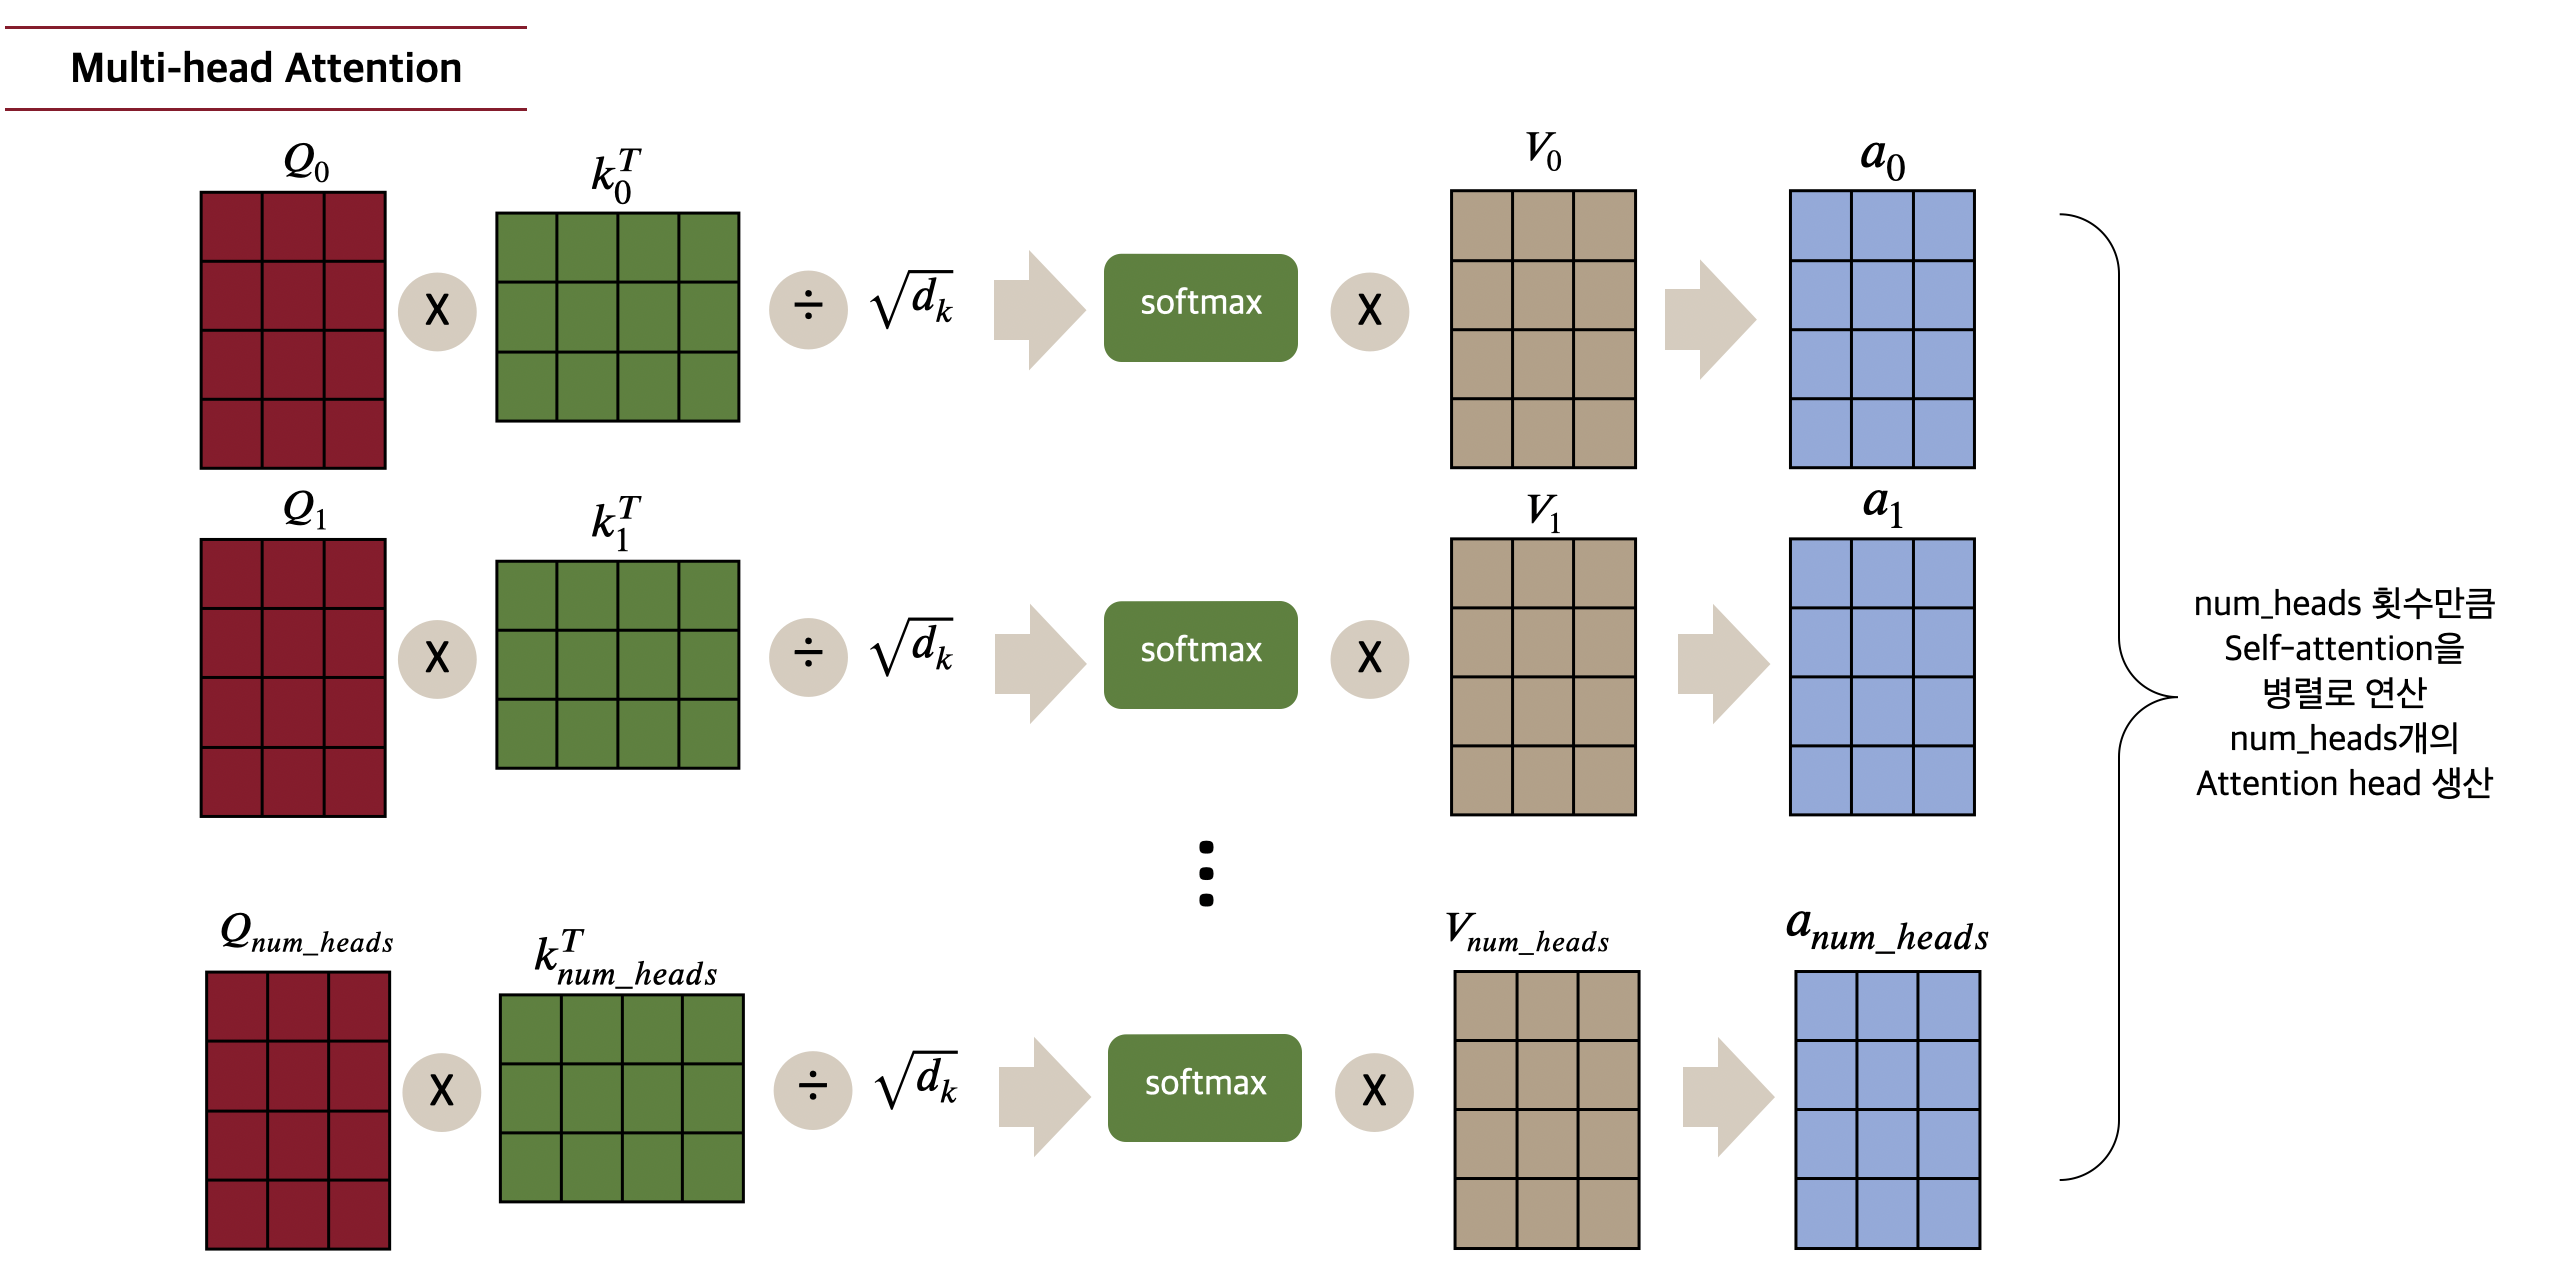

위 그림을 보면 self-attention임을 확인할 수 있습니다. 어텐션을 자기 자신에게 수행한다는 의미입니다. 즉 Q(쿼리), K(키), V(밸류)가 모두 '입력 문장의 모든 단어 벡터'들이 됩니다.

아래 사진에 보이는 scaled dot product이 `MultiHeadAttention` class 안에 구현되어 있습니다.

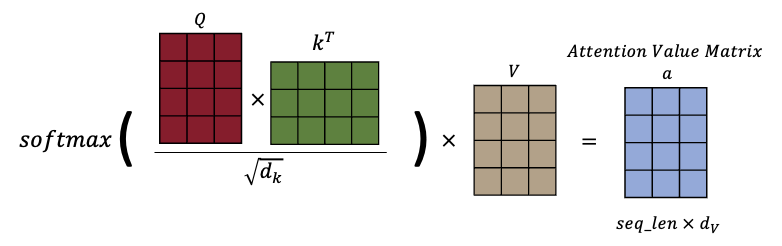

In [30]:
class MultiHeadAttention(nn.Module):

    def __init__(self, heads, d_model):

        super(MultiHeadAttention, self).__init__()
        assert d_model % heads == 0

        """문제2
        Multi-head의 병렬 처리가 가능하게 하려면 벡터의 차원을 적절하게 등분해줘야 합니다.
        d_model을 무엇으로 나누어주어야 할까요?
        """
        self.d_k = d_model // heads # n개의 헤드로 나눠 병렬로 수행

        self.heads = heads
        self.dropout = nn.Dropout(0.1)
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, 512)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        # permute 함수는 차원들을 맞교환함. 행렬곱을 위하여 transpose하는 과정이라 생각하면 됨.
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        """
        문제3: scaled dot product를 구현하여 scores를 계산해봅시다.
        Query, Key 행렬의 차원은 (batch_size, h, max_len, d_k)입니다.
        Key 행렬은 permute 함수를 사용하여 적절하게 transpose할 수 있을 것입니다.
        또한 math.sqrt 함수, size 함수를 적절히 사용하여 분모에 sqrt(d_k) 부분도 표현할 수 있을 것입니다.
        """
        scores = torch.matmul(query, key.permute(0, 1, 3, 2))/math.sqrt(self.d_k)

        # <pad> 토큰이 있는 경우 아주 작은 음수(-1e9)를 곱하여 소프트맥스에 의해 0이 되게끔 함.
        # 즉 단어 간 유사도를 구할 때 <pad> 토큰은 반영이 되지 않게끔 함.
        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
        weights = F.softmax(scores, dim = -1)           # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)
        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # 마지막으로 병렬로 만들어진 모든 어텐션 헤드를 concat해줌.
        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)
        return interacted

## FeedForward

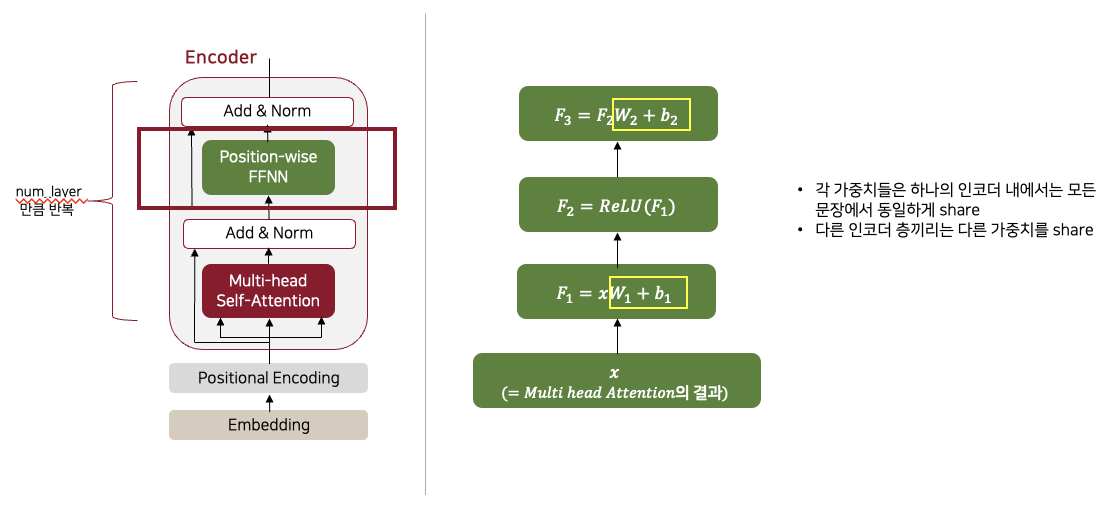

멀티 헤드 어텐션을 통과한 결과물은 feedforward의 입력값으로 사용됩니다.

In [32]:
class FeedForward(nn.Module):

    def __init__(self, d_model, middle_dim = 2048):
        super(FeedForward, self).__init__()

        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):

        """
        문제4: 위 슬라이드 캡쳐본에서 F1, F2에 해당하는 부분을 아래 코드로 작성해주세요.
        hint: activation function은 'torch.nn.functional as F'에서 불러올 수 있습니다.
        """
        out = F.relu(self.fc1(x))

        out = self.fc2(self.dropout(out))
        return out

## 인코더(Encoder) 전체 구조

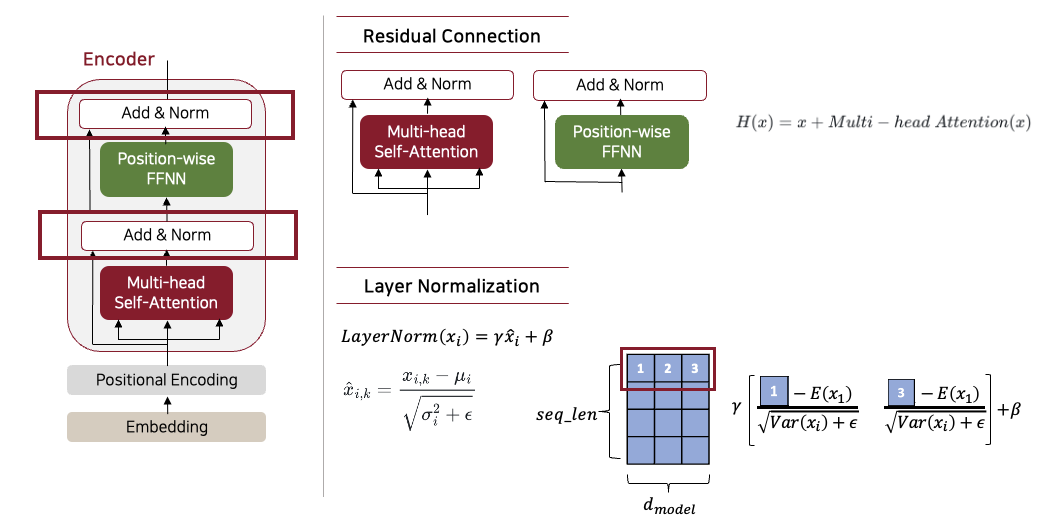

두 개의 서브층인 멀티헤드 셀프어텐션과 FFNN을 지날 때 각각 Add&Norm을 거치고 있습니다. 이는 residual connection과 layer normalization을 수행해준다는 의미입니다.

- residual connection: 서브층의 input + 서브층의 output
- layer normalization: 텐서의 마지막 차원에 대해 평균과 분산을 구하여 어떤 수식을 통해 값을 정규화

In [33]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # interacted(멀티헤드의 output)와 embeddings(멀티헤드의 input)을 더해주고 이를 layernorm(층정규화)시킴
        interacted = self.layernorm(interacted + embeddings)
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        # feed_forward_oout(feedforward의 output)와 interacted(멀티헤드의 output이자 feedforward의 input)을 더해주고
        # 이를 layernorm(층정규화)시킴
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

## 디코더(Decoder) 전체 구조

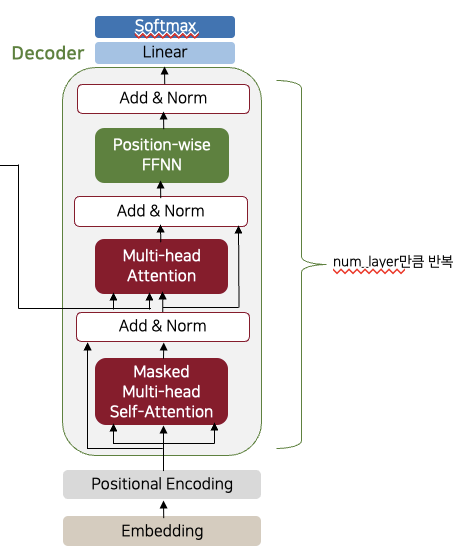

위 사진은 디코더를 시각화한 것입니다. 첫번째 서브층은 self-attention인 반면, 두번째 서브층은 기본적인 attention입니다.

첫번째 서브층에서는 look-ahead mask를 해야하는데, RNN이 매 시점마다 단어를 입력받는 반면, 어텐션은 한꺼번에 단어 행렬을 입력받으므로 미래 시점의 단어까지 참고할 수 있는 상황이 발생해버립니다. 따라서 미래 시점의 단어를 가려주는 look-ahead mask를 실시해주는 것입니다.

두번째 서브층은, self-attention이 아닙니다. 즉, Query가 디코더의 행렬인 반면, Key, Value는 인코더의 행렬입니다. 위 그림의 화살표 모양에서도 이 점을 확인할 수 있습니다.

In [35]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadAttention(heads, d_model)
        self.src_multihead = MultiHeadAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, embeddings, encoded, src_mask, target_mask):
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask)) # look-ahead mask

        """
        문제5: layer normalization을 할 때에는 residual connection을 거쳐야 합니다
        residual connection은 기존 input과 layer를 통과시킨 output을 더해주는 과정이었습니다.
        이 점을 참고하여 코드를 작성해주세요.
        """
        query = self.layernorm(query+embeddings)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))
        interacted = self.layernorm(interacted+query)

        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)
        return decoded

## 트랜스포머(Transformer) 구현

이제 앞서 만든 인코더와 디코더를 조립하여 트랜스포머를 구현할 차례입니다. `num_layers`에 인코더, 디코더 층의 개수를 설정해줄 수 있습니다. 이 층 개수만큼 `ModuleList`를 만들어주어 반복문을 순회하며 인코더, 디코더를 통과하는 원리입니다.

In [36]:
class Transformer(nn.Module):

    def __init__(self, d_model, heads, num_layers, word_map):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.vocab_size = len(word_map)
        self.embed = Embeddings(self.vocab_size, d_model)
        self.encoder = nn.ModuleList([EncoderLayer(d_model, heads) for _ in range(num_layers)]) #num_layers 개수만큼 층 생성
        self.decoder = nn.ModuleList([DecoderLayer(d_model, heads) for _ in range(num_layers)]) #num_layers 개수만큼 층 생성
        self.logit = nn.Linear(d_model, self.vocab_size)

    def encode(self, src_words, src_mask):
        src_embeddings = self.embed(src_words)
        for layer in self.encoder:
            src_embeddings = layer(src_embeddings, src_mask)
        return src_embeddings

    def decode(self, target_words, target_mask, src_embeddings, src_mask):
        tgt_embeddings = self.embed(target_words)
        for layer in self.decoder:
            tgt_embeddings = layer(tgt_embeddings, src_embeddings, src_mask, target_mask)
        return tgt_embeddings

    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim = 2)
        return out

## Learning Rate Sheduler와 손실함수 정의

In [37]:
class AdamWarmup:

    def __init__(self, model_size, warmup_steps, optimizer):

        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0

    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))

    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()

In [38]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size

    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss

## Train and Evaluate

In [41]:
d_model = 512 # 단어 임베딩딩 벡터의 차원원
heads = 8 # 멀티헤드 어텐션 병렬 헤드 개수
num_layers = 3 # 인코더, 디코드의 층 개수수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5

with open('WORDMAP_corpus.json', 'r') as j:
    word_map = json.load(j)

transformer = Transformer(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.1)

/Users/happykuma/miniconda3/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [42]:
def train(train_loader, transformer, criterion, epoch):

    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):

        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # 앞서 만든 마스크 함수를 사용한다.
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # 앞서 정의한 trasnformer 클래스스로 결과를 출력한다.
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)

        # 역전파를 수행한다.
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()

        sum_loss += loss.item() * samples
        count += samples

        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))

In [43]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)

    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)

    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()

    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])

    return sentence

In [ ]:
for epoch in range(epochs):

    train(train_loader, transformer, criterion, epoch)

    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, 'checkpoint_' + str(epoch) + '.pth.tar')

    #### 100개 하는데 5분 이상 걸리기에, 더 나은 환경에서 다시 시도하기 위해 중지함. 

Epoch [0][0/2217]	Loss: 8.693
Epoch [0][100/2217]	Loss: 7.896


KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load('/content/checkpoint_1.pth.tar')
transformer = checkpoint['transformer']

In [ ]:
while(1):
    question = input("Question: ")
    if question == 'quit':
        break
    max_len = input("Maximum Reply Length: ")
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)
    sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
    print(sentence)